# PyCPT SASCOF 2020

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)


#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).



### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work = 'Test5'

########Some folder and file options:
# Where do you want to make the work folder-- this should already exist!!!
workdir = "/Users/kylehall/Projects/PyCPT/PyCPT_SASCOF/"
# PATH to CPT directory (folder containing CPT.x)
cptdir='/Users/kylehall/CPT/16.5.8/'

#Path to local data to use
local_data_dir = "/Users/kylehall/Projects/PYCPT/PyCPT_SASCOF/local_data/"      #should be 'None' or look like workdir
shp_file = "/Users/kylehall/Projects/PYCPT/PyCPT_SASCOF/local_data/sascof_boundary_final.dbf"  #should be either 'None' or look like local_data_dir but plus "shpfile.shp/dbf/shx/etc"

########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']

#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=['Pearson']#,'Spearman']#,'2AFC','RocAbove','RocBelow', 'RMSE']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='local'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA' 


#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5
nmodes = 1 #number of EOF modes to compute

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target season - Either 'JJAS' or 'OND' or 'DJF' or 'All'
season = 'All'



tini = 1982
tend = 2009

########Forecast date  
fyr=2019 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude



### End of namelist section 

#### Load Libraries

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform

setup_directories(work, workdir, force_download, cptdir) #PyCPT Change
tgts, mons, monf, tgti, tgtf = setup_tgts(season) #SASCOF Change


/Users/kylehall/anaconda/envs/pycpt_env37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

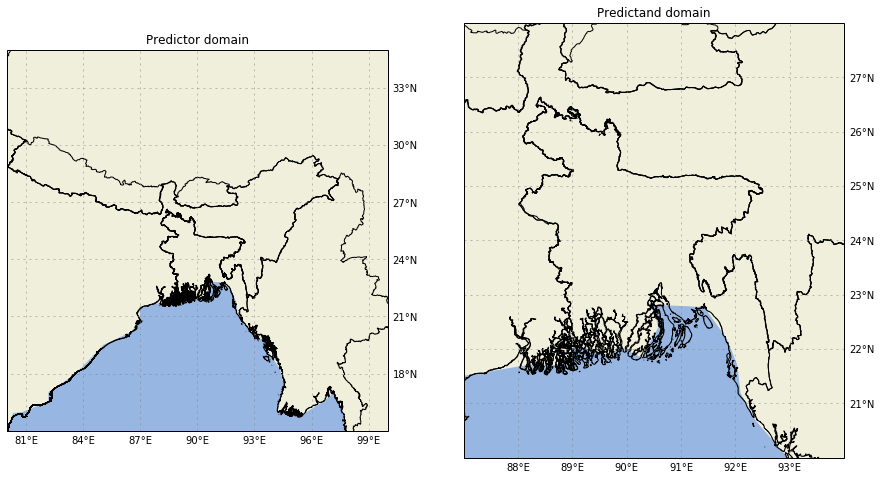

In [3]:
#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2, shp_file=shp_file)

# Download data if necessary, and run CPT

In [4]:

#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('\n\n\n--------Starting process for '+model+'--------')
    for i in range(len(mons)):
        tar, mon = tgts[i], mons[i]
        
        ########Set Up Useful Variables Automatically - tini & tend may change based on tgt
        rainfall_frequency, threshold_pctle, wetday_threshold, obs_source, hdate_last,\
        mpref, L, ntrain, fprefix, nmonths, ndays, file, NGMOS = setup_params(PREDICTOR,obs,MOS,tini,tend, tgts[i])
            
        #download input files for CPT
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti[i], tgtf[i], mon, monf[i], fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download,station,ndays, nmonths, tini, tend, local_data_dir)

        #write CPT input script automatically
        CPTscript(model,PREDICTAND, mon,monf[i], fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend, local_data_dir)

        #run CPT
        RunCPT(cptdir, model, tar, mon)
        




--------Starting process for COLA-RSMAS-CCSM4--------
Predictand is Rainfall Total (mm)
Obs option is invalid - if you're using local data this is OK
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Hindcasts file ready to go
----------------------------------------------
Found Your DATA
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
Using your Data
Executing CPT for COLA-RSMAS-CCSM4 and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_COLA-RSMAS-CCSM4_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Obs option is invalid - if you're using local data this is OK
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Hindcasts fil

## Deterministic Skill Analysis


Pearson


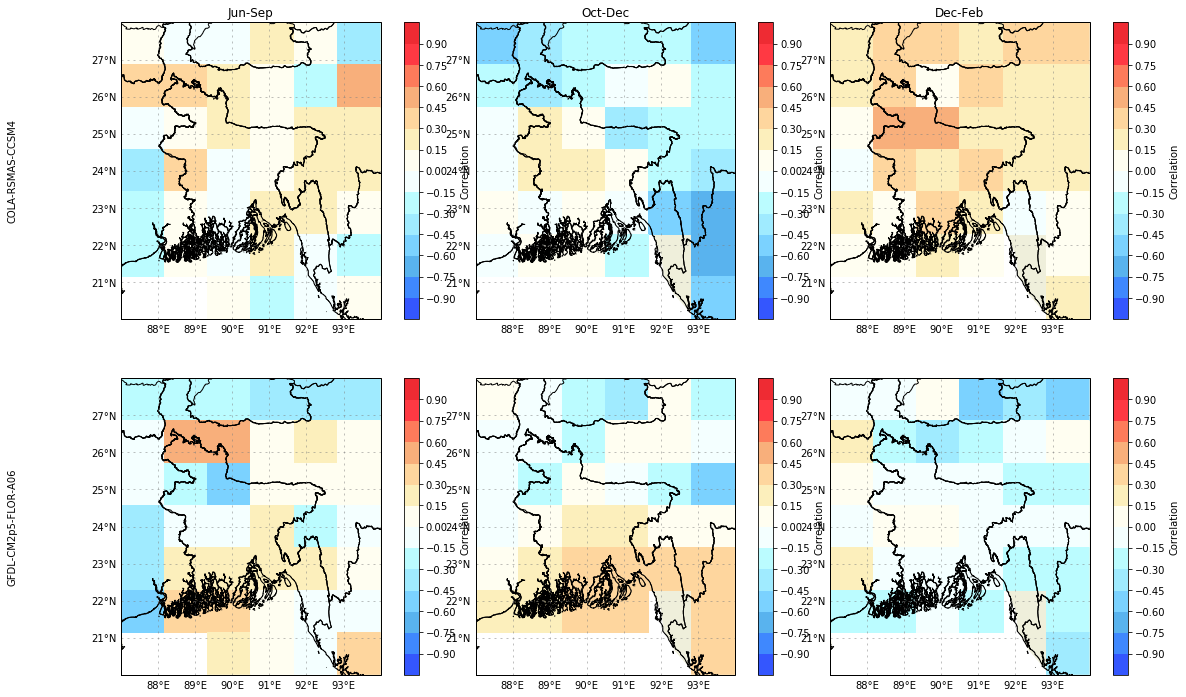

In [5]:
# Skill scores loop
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,mons, obs, shp_file=shp_file)   


##### EOF Analysis (only available if MOS=PCR or CCA)




-------------EOF 1-------------



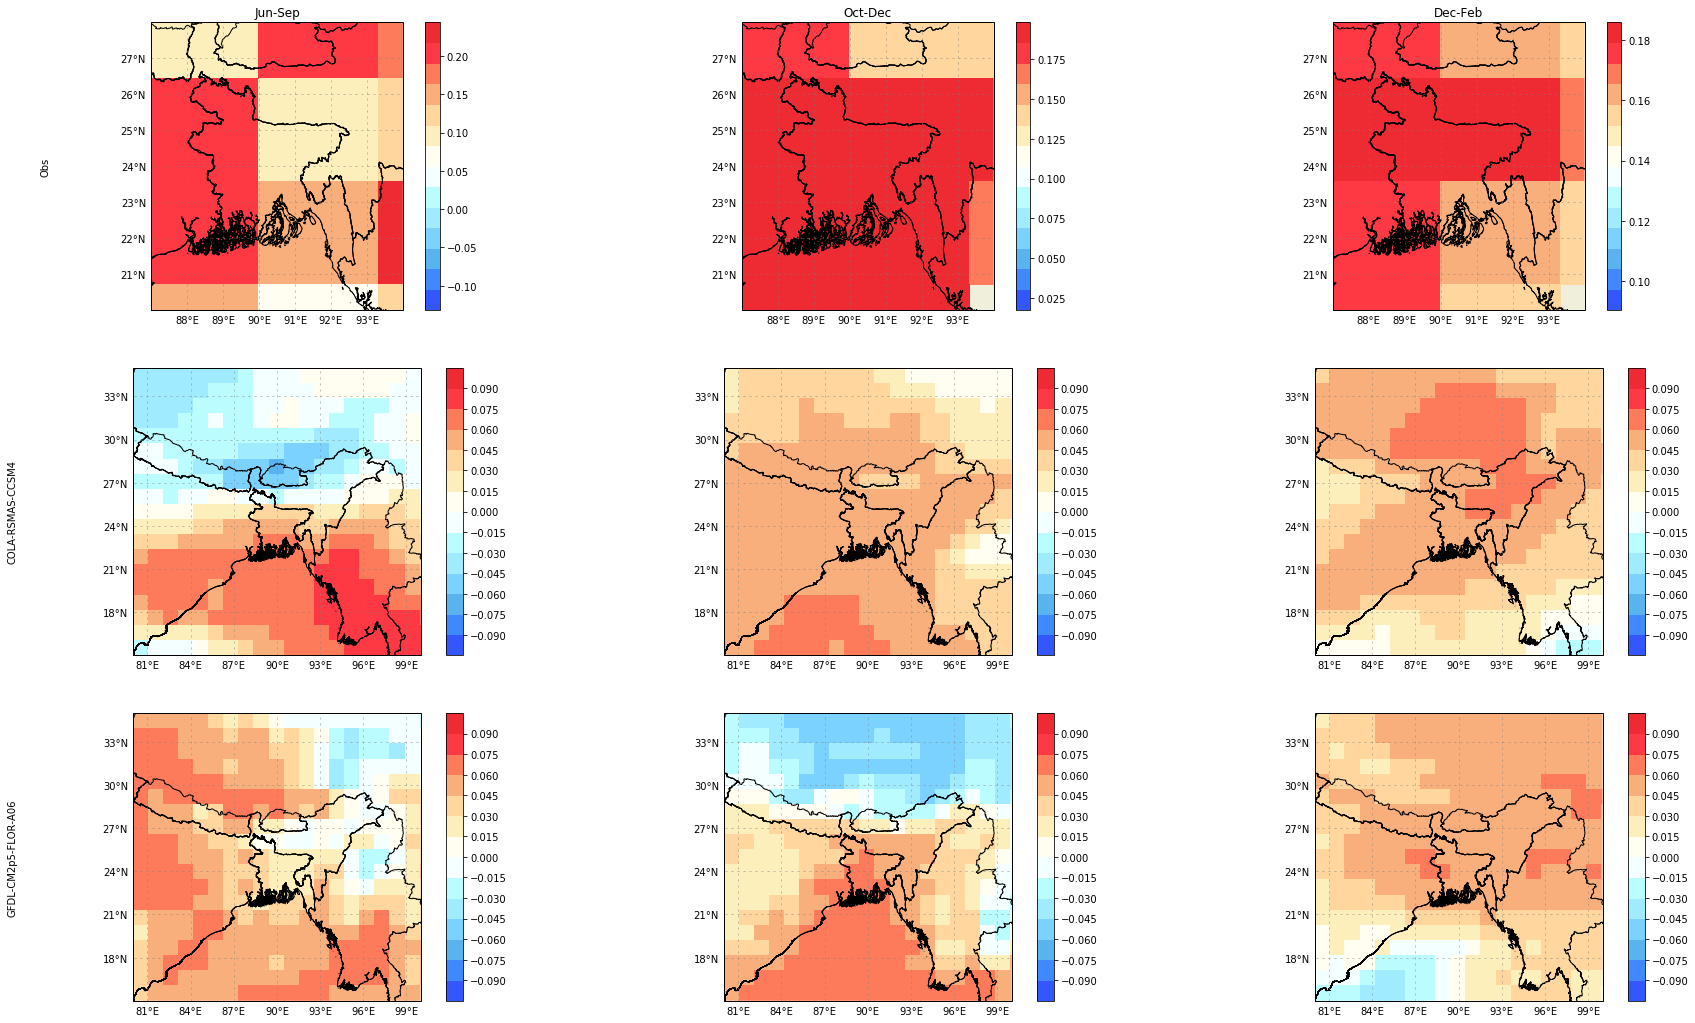

In [6]:
# Skill scores loop
if MOS in ['PCR', 'CCA']:
    for imod in range(nmodes):
        plteofs(models,PREDICTAND,imod,nmodes,wlo1,elo1,sla1,nla1,wlo2,elo2,sla2,nla2, fprefix,mpref,tgts, mons,mons,fyr, obs, shp_file=shp_file)  

## Multi-model ensemble: NextGen

In [7]:
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']

for i in range(len(mons)):
    tar, mon =tgts[i], mons[i]

    #prepare files for nextgen input using simple mean
    NGensemble(models,fprefix,PREDICTAND,mpref,file,tar,mon,tgti[i],tgtf[i],monf[i],fyr)

    #write CPT input script for NextGen
    CPTscript('NextGen',PREDICTAND, mon,monf[i], fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,NGMOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, tini, tend, local_data_dir)

    #run CPT for nextgen
    RunCPT(cptdir, 'NextGen', tar, mon)

Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization May...
Cross-validated prediction files successfully produced
Using your Data
Executing CPT for NextGen and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...
Cross-validated prediction files successfully produced
Using your Data
Executing CPT for NextGen and initialization Sep...
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Oct-Dec_Sep.txt for errors
-------------------


Pearson


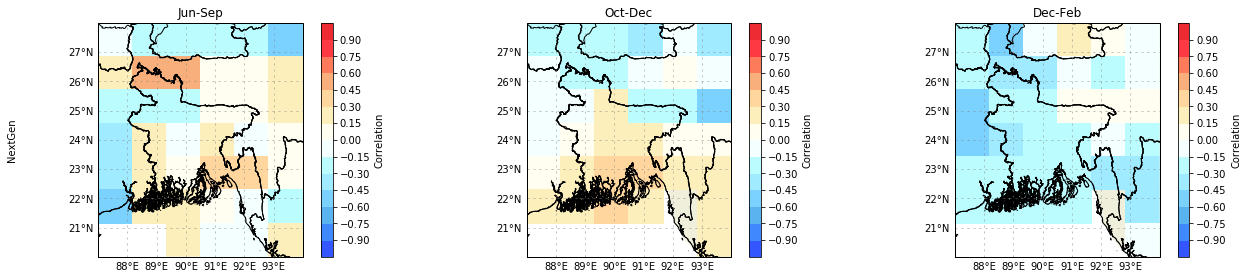

In [8]:
# Skill scores loop
for ime in met:
    pltmap(['NextGen'],PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,mons, obs, shp_file=shp_file)   

# Real-Time Forecast

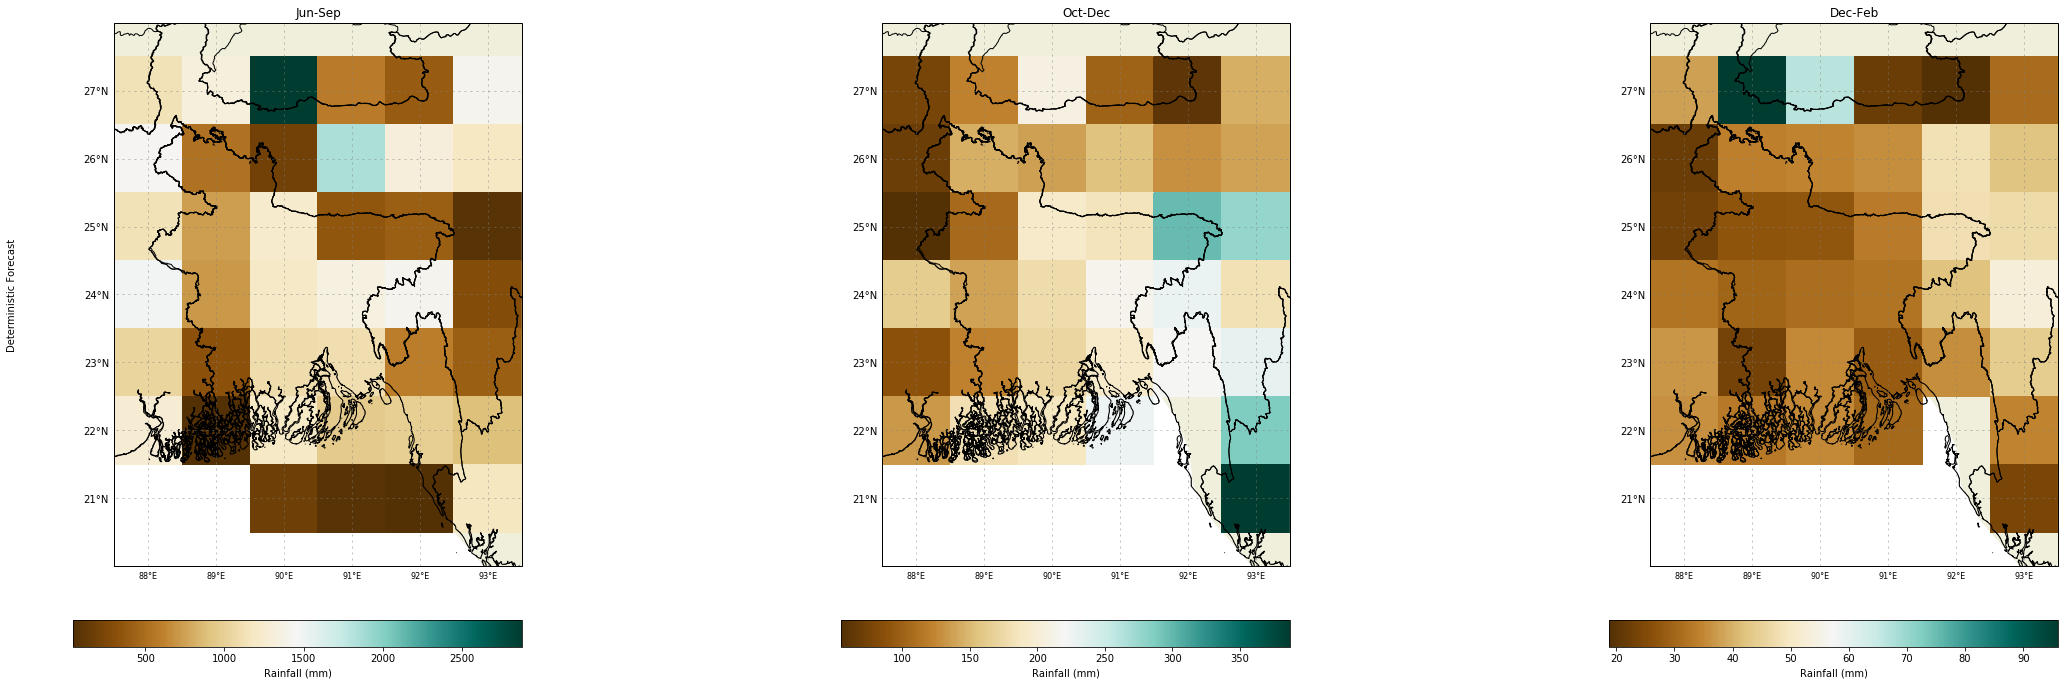

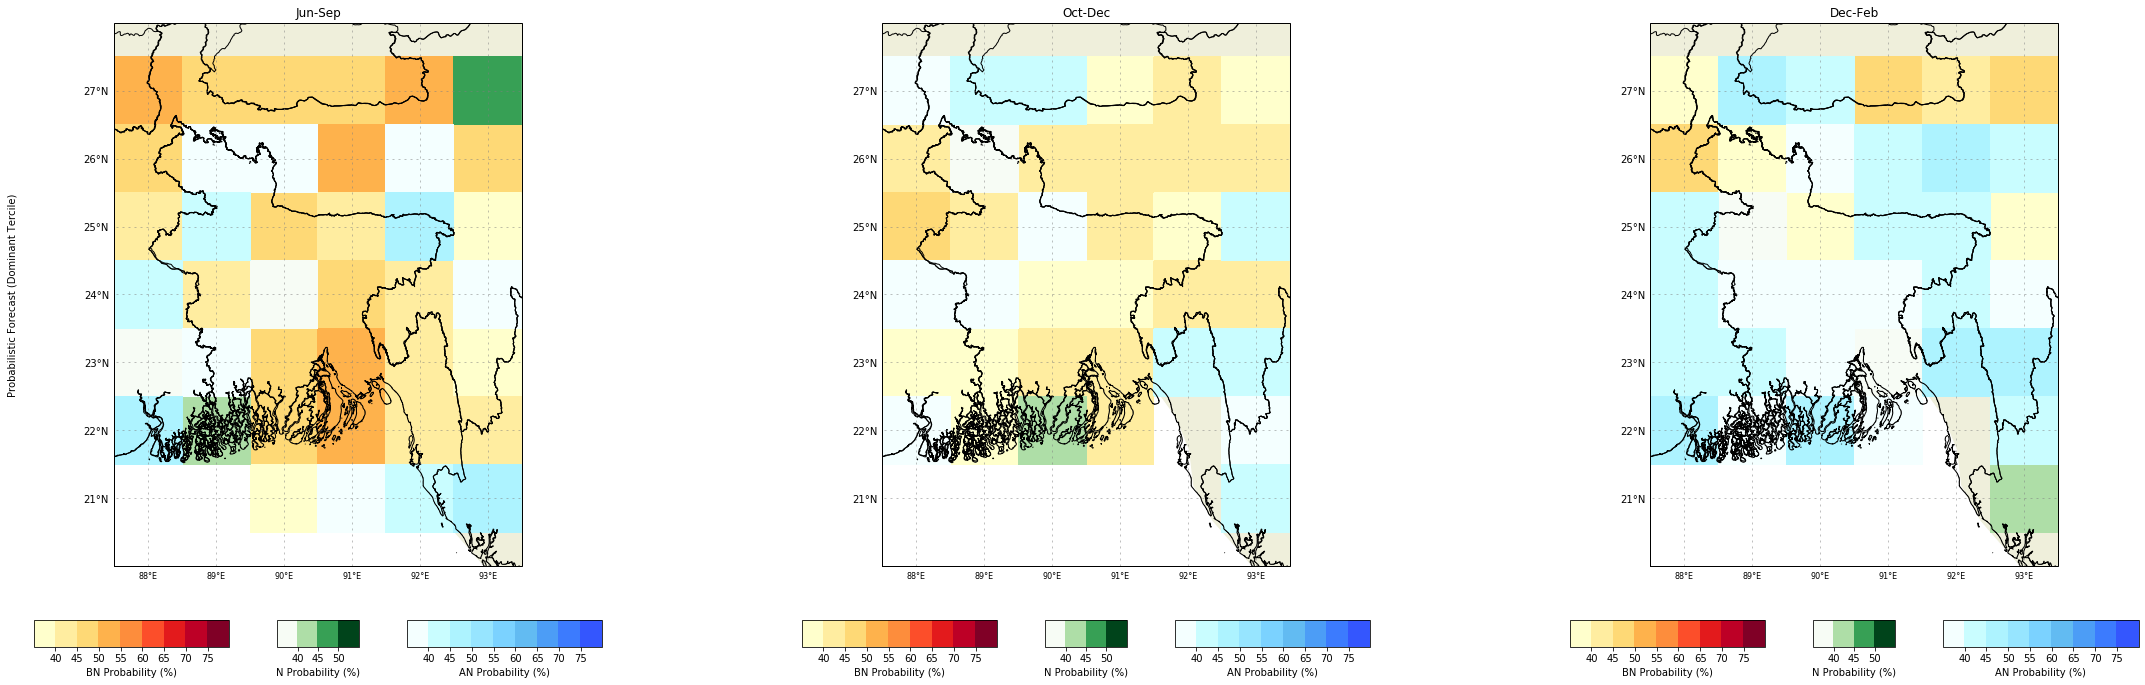

In [9]:
plt_ng_deterministic(['NextGen'], PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, tgts, mons, fyr, shp_file=shp_file)
plt_ng_probabilistic(['NextGen'], PREDICTAND, wlo2,elo2,sla2,nla2, fprefix, mpref, tgts, mons, fyr, shp_file=shp_file)

In [10]:
ensemblefiles(['NextGen'],work)

mkdir: ./output/NextGen/: File exists
a ./output/NextGen/NextGen_PRCP_CCAFCST_Obs_Dec-Feb_Nov2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_Obs_Jun-Sep_May2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_Obs_Oct-Dec_Sep2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_P_Dec-Feb_Nov2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_P_Jun-Sep_May2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_P_Oct-Dec_Sep2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_mu_Dec-Feb_Nov2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_mu_Jun-Sep_May2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_mu_Oct-Dec_Sep2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_var_Dec-Feb_Nov2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_var_Jun-Sep_May2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_var_Oct-Dec_Sep2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_xvPr_Dec-Feb_Nov2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_xvPr_Jun-Sep_May2019.txt
a ./output/NextGen/NextGen_PRCP_CCAFCST_xvPr_Oct-Dec_Sep2019.txt
a ./outp